0. Smoothing operator (some normalized constant matrix)
1. Gaussian operator (obtained by outer product of a Gaussian 1D kernel with itself)
2. Sobel operator (obtained by multiplying x- or y-derivative filters with some smoothing filter(1D) in the other direction)
3. Prewitt operator (x- and y-derivative filters are weighted with the standard averaging filter)
4. Scharr operator (resulting from an optimization minimizing weighted mean squared angular error in the Fourier domain)

In [52]:
import sys
!{sys.executable} -m pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.3/30.3 MB 32.2 MB/s eta 0:00:00a 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import cv2
import os
from scipy.signal import convolve2d

/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")
IMG_DIR = path + "/LEGO brick images v1/2357 Brick corner 1x2x2/"

In [69]:
files = os.listdir(IMG_DIR)
# list all files within IMG_DIR
print(IMG_DIR)
files[-5:]

/Users/anvay-coder/.cache/kagglehub/datasets/joosthazelzet/lego-brick-images/versions/4/LEGO brick images v1/2357 Brick corner 1x2x2/


['201706171206-0269.png',
 '201706171206-0255.png',
 '201706171206-0241.png',
 '201706171206-0296.png',
 '201706171206-0282.png']

(200, 200)

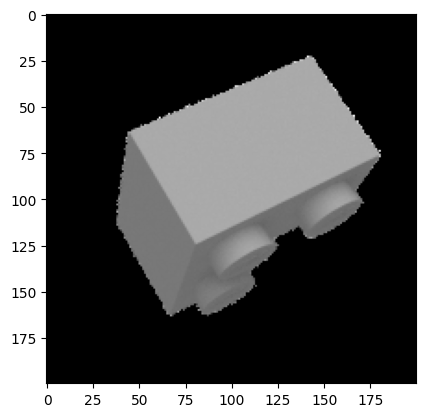

In [7]:
img = cv2.imread(IMG_DIR + "/201706171206-0243.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
img.shape

In [11]:
# we must have odd-sized kernel to avoid aliasing error wrt what the centre of convolution sum is
def myconvolve2d(img, kernel):
    kernel_height = kernel.shape[0]
    kernel_height_halved = int((kernel_height-1)/2)
    kernel_width = kernel.shape[1]
    kernel_width_halved = int((kernel_width-1)/2)
    img = np.pad(img, ((kernel_height_halved, kernel_height_halved), 
                       (kernel_width_halved, kernel_width_halved)), 
                 mode='constant', constant_values=0)
    img_height = img.shape[0]
    img_width = img.shape[1]
    convolution = []
    # start at row kernel_height_halved, end at row img_height-kernel_height_halved
    for i in range(kernel_height_halved, img_height-kernel_height_halved):
        lst = []
        # start at col kernel_width_halved, end at col img_width-kernel_height_halved
        for j in range(kernel_width_halved, img_width-kernel_width_halved):
            lst.append((img[i-kernel_height_halved:i+kernel_height_halved+1,
                            j-kernel_width_halved:j+kernel_width_halved+1] * kernel).sum().item())
        convolution.append(lst)
    return np.array(convolution)

In [64]:
# helper functions for Gaussian and myGaussianKernel
import math
def gaussian(x, sigmaX=1, mu=0):
    return (1 / (sigmaX * (2*math.pi)**0.5) * math.e ** (-0.5 * ((x-mu)/sigmaX)**2))

def myGaussianKernel(ksize, sigmaX):
    # get the center of the kernel
    center_y = (ksize[0]-1)/2
    center_x = (ksize[1]-1)/2
    sum = 0 # for normalization
    kernel = []
    for y in range(ksize[0]):
        row = []
        for x in range(ksize[1]):
            delta_y = y - center_y
            delta_x = x - center_x
            gaussian_x_y = gaussian((delta_x**2 + delta_y**2)**0.5, sigmaX, mu=0)
            sum += gaussian_x_y
            row.append(gaussian_x_y)
        kernel.append(row)
    kernel_np = np.array(kernel, dtype=float)
    return kernel_np/sum

In [65]:
gaussian_kernel_height = 7
gaussian_kernel_width = 7
sigmaX = 2.0
gk1 = cv2.getGaussianKernel(gaussian_kernel_height, sigmaX)
gk2 = cv2.getGaussianKernel(gaussian_kernel_width, sigmaX)
outer_gk = np.outer(gk1, gk2)
outer_gk # equivalent mathematically to myGaussianKernel((gaussian_kernel_height, gaussian_kernel_width))

array([[0.00492233, 0.00919613, 0.01338028, 0.01516185, 0.01338028,
        0.00919613, 0.00492233],
       [0.00919613, 0.01718062, 0.02499766, 0.02832606, 0.02499766,
        0.01718062, 0.00919613],
       [0.01338028, 0.02499766, 0.03637138, 0.04121417, 0.03637138,
        0.02499766, 0.01338028],
       [0.01516185, 0.02832606, 0.04121417, 0.04670178, 0.04121417,
        0.02832606, 0.01516185],
       [0.01338028, 0.02499766, 0.03637138, 0.04121417, 0.03637138,
        0.02499766, 0.01338028],
       [0.00919613, 0.01718062, 0.02499766, 0.02832606, 0.02499766,
        0.01718062, 0.00919613],
       [0.00492233, 0.00919613, 0.01338028, 0.01516185, 0.01338028,
        0.00919613, 0.00492233]])

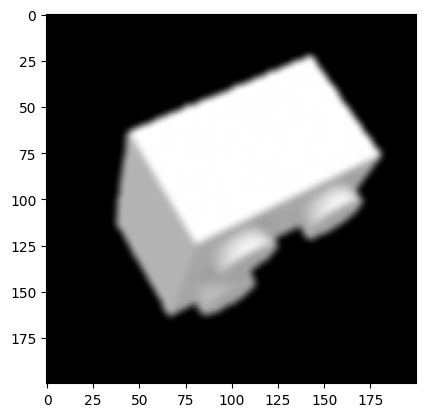

In [66]:
# img_blur = convolve2d(img, outer_gk, mode='same', boundary='fill', fillvalue=0)
img_blur = myconvolve2d(img, myGaussianKernel((gaussian_kernel_height, gaussian_kernel_width), sigmaX))
plt.imshow(img_blur, cmap='gray')

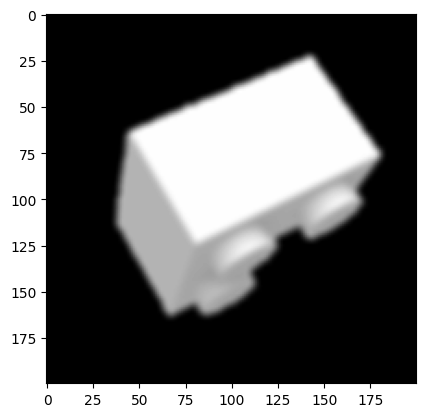

In [68]:
rgb = cv2.GaussianBlur(img, (gaussian_kernel_height,gaussian_kernel_width), sigmaX)
plt.imshow(rgb, cmap='gray')

In [201]:
# Sobel operator (3x3 case)

# Sobel x-operator gives high convolution result with high change in intensity horizontally
# Since this detects change in intensity horizontally, it detects vertical edges

# we want to focus on the change in center row with Gaussian weights
gaussian_vertical_filter = np.array([[1], [2], [1]], dtype=np.int8)
# x-derivative that denotes horizontal change multiplier
x_derivative = np.array([[-1, 0, 1]], dtype=np.int8)
sobel_x = np.dot(gaussian_vertical_filter, x_derivative)
sobel_x

array([[-1,  0,  1],
       [-2,  0,  2],
       [-1,  0,  1]], dtype=int8)

In [202]:
# Sobel y-operator

# Sobel y-operator gives high convolution result with high change in intensity vertically
# Since this detects change in intensity vertically, it detects horizontal edges

# y-derivative that denotes vertical change multiplier
y_derivative = np.array([[-1], [0], [1]], dtype=np.int8)
# we want to focus on the change in center column with Gaussian weights
gaussian_horizontal_filter = np.array([[1, 2, 1]], dtype=np.int8)
sobel_y = np.dot(y_derivative, gaussian_horizontal_filter)
sobel_y

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]], dtype=int8)

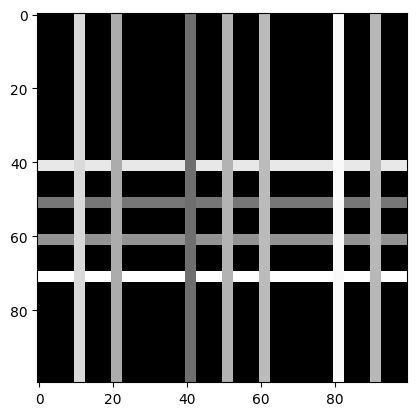

In [203]:
# generate random 100x100 image array with horizontal and vertical edges that are `width` pixels wide
random_image = np.zeros((100, 100), dtype=np.uint8)
width = sobel_x.shape[0]

# generate random horizontal edges
for i in range(0, 100-width, 10):
    if np.random.rand() > 0.5:
        # assign the three pixels from current one some intensity from 100 to 255
        random_image[i:i+width, :] = np.random.randint(100, 256)

# generate random vertical edges
for j in range(0, 100-width, 10):
    if np.random.rand() > 0.5:
        # assign the three pixels from current one some intensity from 100 to 255
        random_image[:, j:j+width] = np.random.randint(100, 256)

plt.imshow(random_image, cmap='gray')

(200, 200)

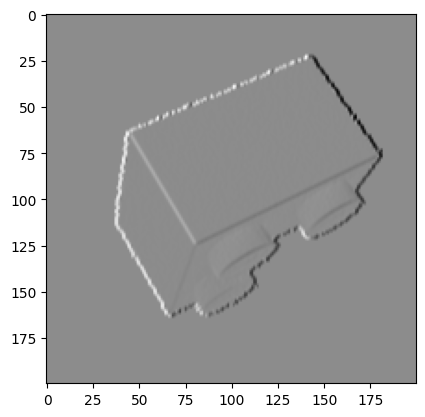

In [267]:
# Apply the sobel_x kernel to the random_image
# sobel_x_result = convolve2d(img, sobel_x, mode='same', boundary='fill', fillvalue=0)
my_img_sobel_x = myconvolve2d(img, sobel_x)
plt.imshow(my_img_sobel_x, cmap='gray')
my_img_sobel_x.shape

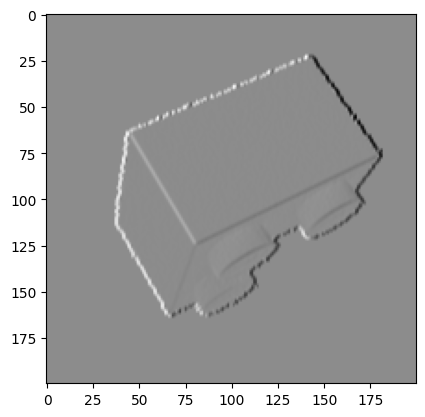

In [268]:
sobel_x_result = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0)
plt.imshow(sobel_x_result, cmap='gray')

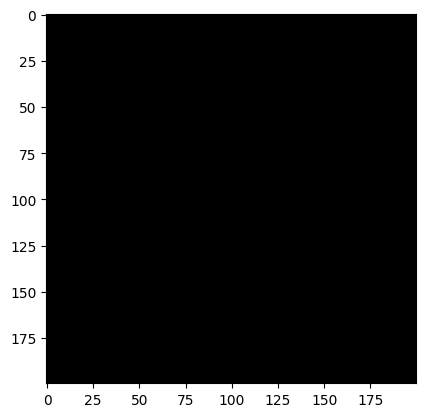

In [274]:
# difference between my Sobel-x operator and cv2's Sobel-x operator; result should be all black
plt.imshow(my_img_sobel_x-sobel_x_result, cmap='gray')

(200, 200)

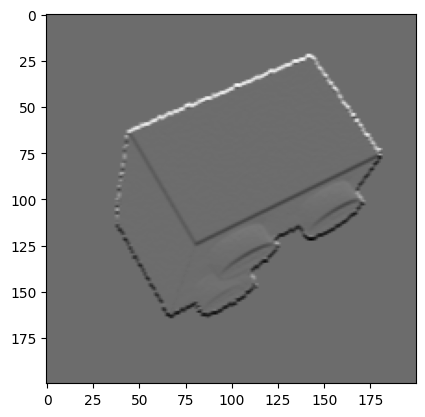

In [275]:
# Apply the sobel_y kernel to the random_image
# sobel_y_result = convolve2d(img, sobel_y, mode='same', boundary='fill', fillvalue=0)
my_img_sobel_y = myconvolve2d(img, sobel_y)
plt.imshow(my_img_sobel_y, cmap='gray')
my_img_sobel_y.shape

(200, 200)

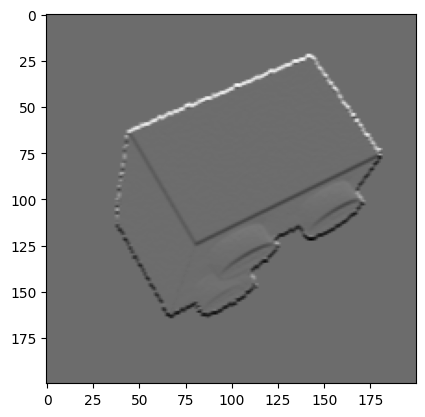

In [276]:
sobel_y_result = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=0, dy=1)
plt.imshow(sobel_y_result, cmap='gray')
sobel_y_result.shape

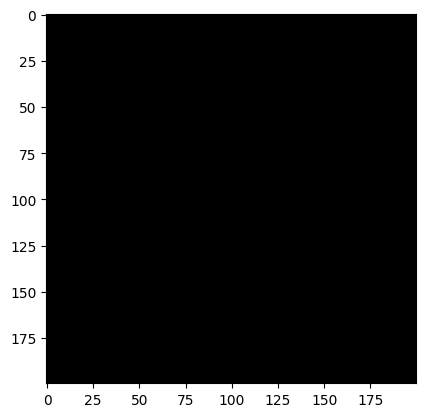

In [278]:
# difference between my Sobel-y operator and cv2's Sobel-y operator; result should be all black
plt.imshow(my_img_sobel_y-sobel_y_result, cmap='gray')

In [293]:
sobel_x = cv2.getDerivKernels(1, 0, 7)
print(sobel_x[0])
print(sobel_x[1])
outer_sobel = np.outer(sobel_x[0], sobel_x[1])
outer_sobel

[[-1.]
 [-4.]
 [-5.]
 [ 0.]
 [ 5.]
 [ 4.]
 [ 1.]]
[[ 1.]
 [ 6.]
 [15.]
 [20.]
 [15.]
 [ 6.]
 [ 1.]]


array([[  -1.,   -6.,  -15.,  -20.,  -15.,   -6.,   -1.],
       [  -4.,  -24.,  -60.,  -80.,  -60.,  -24.,   -4.],
       [  -5.,  -30.,  -75., -100.,  -75.,  -30.,   -5.],
       [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [   5.,   30.,   75.,  100.,   75.,   30.,    5.],
       [   4.,   24.,   60.,   80.,   60.,   24.,    4.],
       [   1.,    6.,   15.,   20.,   15.,    6.,    1.]], dtype=float32)

In [298]:
sobel_y = cv2.getDerivKernels(0, 1, 9)
print(sobel_y[0])
print(sobel_y[1])
outer_sobel_y = np.outer(sobel_y[0], sobel_y[1])
outer_sobel_y

[[ 1.]
 [ 8.]
 [28.]
 [56.]
 [70.]
 [56.]
 [28.]
 [ 8.]
 [ 1.]]
[[ -1.]
 [ -6.]
 [-14.]
 [-14.]
 [  0.]
 [ 14.]
 [ 14.]
 [  6.]
 [  1.]]


array([[  -1.,   -6.,  -14.,  -14.,    0.,   14.,   14.,    6.,    1.],
       [  -8.,  -48., -112., -112.,    0.,  112.,  112.,   48.,    8.],
       [ -28., -168., -392., -392.,    0.,  392.,  392.,  168.,   28.],
       [ -56., -336., -784., -784.,    0.,  784.,  784.,  336.,   56.],
       [ -70., -420., -980., -980.,    0.,  980.,  980.,  420.,   70.],
       [ -56., -336., -784., -784.,    0.,  784.,  784.,  336.,   56.],
       [ -28., -168., -392., -392.,    0.,  392.,  392.,  168.,   28.],
       [  -8.,  -48., -112., -112.,    0.,  112.,  112.,   48.,    8.],
       [  -1.,   -6.,  -14.,  -14.,    0.,   14.,   14.,    6.,    1.]],
      dtype=float32)

In [ ]:
# Scharr operator


In [ ]:
# Prewitt operator
